# Imports

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import ML_lib
import importlib
import os

# for debug purposes, reload the module to reflect recent changes
importlib.reload(ML_lib)

<module 'ML_lib' from 'c:\\Users\\maxim\\Godot Games\\Snake\\python-test-folder\\ML_lib.py'>

# Loading CSV data

In [10]:
def load_and_preprocess_data(data_path):
    # iterate over all the csv files in the data_path, remove the header and combine them into one np.array
    data_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
    data_list = []

    print(f"Found {len(data_files)} csv files in {data_path}")

    for file in data_files:
        file_path = os.path.join(data_path, file)
        try:
            data = np.loadtxt(file_path, delimiter=',', skiprows=1)
            if data.size > 0:
                # Ensure 2D array even if single line
                if len(data.shape) == 1:
                    data = data.reshape(1, -1)
                
                # ============================================================
                # DATA FIX: Impute 'No Input' ([0,0,0,0]) with Last Direction
                # ============================================================
                # We assume the last 4 columns are the One-Hot direction [Up, Right, Down, Left]
                # Default to [0, 1, 0, 0] (Right), the game starts with no input
                last_action = np.array([0, 1, 0, 0], dtype=data.dtype)

                for i in range(len(data)):
                    # Check the last 4 columns (targets)
                    current_y = data[i, -4:]
                    
                    # If sum is 0, it means no key was pressed -> Snake continues previous direction
                    if np.sum(current_y) == 0:
                        data[i, -4:] = last_action
                    else:
                        # New input found, update the last known action
                        last_action = current_y
                # ============================================================

                data_list.append(data)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not data_list:
        print("No data loaded.")
        return None, None

    combined_data = np.concatenate(data_list, axis=0)
    print(f"Original combined shape: {combined_data.shape}")

    # Filter rows where score (col 1) resets to 0 in the next row, but is not 0 itself
    # Logic: (current_score != 0) AND (next_score == 0) -> Remove current
    
    to_remove = np.zeros(len(combined_data), dtype=bool)
    
    # Check condition for all rows except the last one
    # Column 1 is the score column
    to_remove[:-1] = (combined_data[:-1, 1] != 0) & (combined_data[1:, 1] == 0)
    
    num_removed = np.sum(to_remove)
    print(f"Removing {num_removed} rows where score resets to 0.")
    
    combined_data_filtered = combined_data[~to_remove]
    
    # Remove the first column (index 0) gameOver not relevant
    combined_data_final = combined_data_filtered[:, 1:]
    
    print(f"Shape after filtering rows and removing first column: {combined_data_final.shape}")

    # use the last 4 row as the prediction and the rest as the features
    X = combined_data_final[:, :-4]
    Y = combined_data_final[:, -4:]

    print(f"Final X shape: {X.shape}")
    print(f"Final Y shape: {Y.shape}")
    
    # print the size of X in MB
    print("Size of X: ", X.nbytes / 1e6, "MB")
    
    return X, Y

In [11]:
X, Y = load_and_preprocess_data("../Data/")

Found 2 csv files in ../Data/
Original combined shape: (7322, 525)
Removing 20 rows where score resets to 0.
Shape after filtering rows and removing first column: (7302, 524)
Final X shape: (7302, 520)
Final Y shape: (7302, 4)
Size of X:  30.37632 MB


In [21]:
NPL = [520, 256, 128, 64, 32, 4]

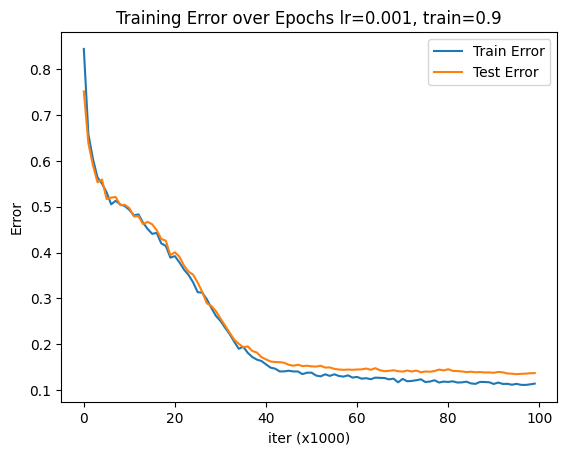

In [22]:
mlp = ML_lib.MLP(NPL, True)

num_iter = 100_000
error_list_size = 100
lr = 0.001
train_proportion = 0.9

train_err, test_err = mlp.train(X.T, Y.T, num_iter = num_iter, lr=lr, 
                            train_proportion=train_proportion, error_list_size=error_list_size)

plt.plot(train_err, label="Train Error")
plt.plot(test_err, label="Test Error")
plt.xlabel(f"iter (x{num_iter//error_list_size})")
plt.ylabel("Error")
plt.title(f"Training Error over Epochs lr={lr}, train={train_proportion}")
plt.legend()
plt.show()

In [23]:
# Predict 10 random samples from X and print them and the corresponding Y
for idx in range(10):
    x_sample = X[idx, :].reshape(-1, 1)
    y_true = Y[idx, :].reshape(-1, 1)
    y_pred = mlp.predict(x_sample)
    print(f"Sample {idx}:")
    print(f"  True Output: {y_true.ravel()}")
    print(f"  Predicted Output: {y_pred.ravel()}")

Sample 0:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [ 0.6805235   0.76985415  0.05349824 -0.27290086]
Sample 1:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [ 0.3145807   0.53001779  0.26048493 -0.24661553]
Sample 2:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [-0.05674489  0.41082429  0.22173716  0.18532887]
Sample 3:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [ 0.02414806  0.62379786  0.1216111  -0.03866341]
Sample 4:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.01865977 0.59023796 0.01034879 0.31658829]
Sample 5:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.10568188 0.50660711 0.16376415 0.28546344]
Sample 6:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [0.10950754 0.24527293 0.44102181 0.67252283]
Sample 7:
  True Output: [0. 1. 0. 0.]
  Predicted Output: [-0.19362832  0.26779899  0.30514979  0.59784265]
Sample 8:
  True Output: [0. 0. 0. 1.]
  Predicted Output: [ 0.43864384 -0.04144207  0.02098879  0.54344531]
Sample 9:
  True Output: [0. 0.

In [25]:
path = f"..\\Models\\{X.shape[0]}X_{NPL}_{num_iter}iter_{lr}lr_{train_proportion}train.bin"
mlp.save(path)
print(f"Model saved to {path}")

Model saved to ..\Models\7302X_[520, 256, 128, 64, 32, 4]_100000iter_0.001lr_0.9train.bin


In [7]:
loaded_mlp = ML_lib.MLP.load("..\\Models\\7302X_520+256+128+64+32+4_10kiter_0.01lr_0.9train.bin")
loaded_mlp_predict = loaded_mlp.predict(x_sample)
print(f"Loaded MLP Predicted Output: {loaded_mlp_predict.shape}")

Loaded MLP Predicted Output: (4,)


# Observation

The model perform pourly when the user doesn't give any input (all zeros). It has trouble predicting the right output in that case. It's not clear what 0,0,0,0 is and model doesn't know how to handle it.

- option 1: add a 5th neuron to indicate "no input". Issue, can mean many things Up, Down, Left, Right. Would require the model to know what was the last action
- option 2: add a threshold (tried and didn't work well)
- option 3: change the data to replace the 0,0,0,0 with the last taken action. 